# Hands on 06 - Pré processamento e aumentação de dados para Deep Learning

Redes neurais, na maioria das vezes, esperam algum tipo de dados estruturado e bem comportado como entrada. Na vida real (mesmo na astronomia/física) isso muitas vezes não é o caso, e recai sobre o pesquisador/aluno trabalhar os dados antes de utilizá-los para treinar uma rede. A parte de pré-processamento é uma das mais importantes durante um trabalho de Deep Learning e pode tomar muito tempo. Algumas vezes essa parte pode tomar mais tempo do que a definição da arquitetura da rede.

Além disso, muitas vezes o modo como fazemos esse tratamento inicial pode impactar bastante no resultado final. Não existe receita de bolo para esse tratamento, mas aqui iremos demonstrar algumas práticas importantes. Falaremos também sobre aumentação de dados e como isso pode melhorar o treinamento de uma rede.

In [4]:
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import tensorflow as tf

In [3]:
!wget https://www.dropbox.com/s/dppbwbue7ombt9c/502nmos.zip?dl=0
!wget https://www.dropbox.com/s/6c3zruv6v3h813u/656nmos.zip?dl=0
!wget https://www.dropbox.com/s/y1wv28xe3he656s/673nmos.zip?dl=0
!wget https://www.dropbox.com/s/v2scc4n5853nwfa/hjy_cut_test_o2i.npy?dl=0
!wget https://www.dropbox.com/s/t62xefeo4pk4fqf/saint_bernard_stanford.jpg?dl=0
!wget https://www.dropbox.com/s/7tzv6m29y7sbuwk/vis_cut_test_o2i.npy?dl=0
!wget https://www.dropbox.com/s/bnridgu4dtno1ti/y_cut_test_o2i.npy?dl=0

--2023-02-01 15:14:57--  https://www.dropbox.com/s/dppbwbue7ombt9c/502nmos.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dppbwbue7ombt9c/502nmos.zip [following]
--2023-02-01 15:14:57--  https://www.dropbox.com/s/raw/dppbwbue7ombt9c/502nmos.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc98cfe4e4676ef55faa56e0161c.dl.dropboxusercontent.com/cd/0/inline/B1r409CezLMex7BPPljm7uZUPvI5noJqonyDW6V5sg0kq-B3XqRO8ee0GyaVSjINaQuP2WuLKWZYTx63hi33XfBCkt2hSaiJY5xI3HUoc3QmkBtB_khIOaLfy7RYl924lda2utUDK_weZXn0GyRUCJ924SFrgUaK0eOIZ86JlPuEqA/file# [following]
--2023-02-01 15:14:58--  https://uc98cfe4e4676ef55faa56e0161c.dl.dropboxusercontent.com/cd/0/inline/B1r409CezLMex7BPPljm7uZUPvI5noJqonyDW6V5sg0kq-B3XqRO8ee0GyaVSjINaQuP2WuLKWZYTx

## 1. Ler imagens em python

Imagens vindas da internet, como em desafios de dados, estão em formatos como `.jpeg` ou `.png`. O pacote [scikit-image](https://scikit-image.org), por exemplo, é especializado em trabalhar com imagens. 

Existem outros ([Pillow](https://pillow.readthedocs.io/en/stable/), [imageio](https://pypi.org/project/imageio/), [OpenCV](https://pypi.org/project/opencv-python/))

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dog = io.imread('/content/saint_bernard_stanford.jpg?dl=0')
print(type(dog), dog.shape)

<class 'numpy.ndarray'> (266, 400, 3)


In [ ]:
print(f'Menor valor de pixel = {dog.min()}\nMaior valor do pixel = {dog.max()}')

Menor valor de pixel = 0
Maior valor do pixel = 255


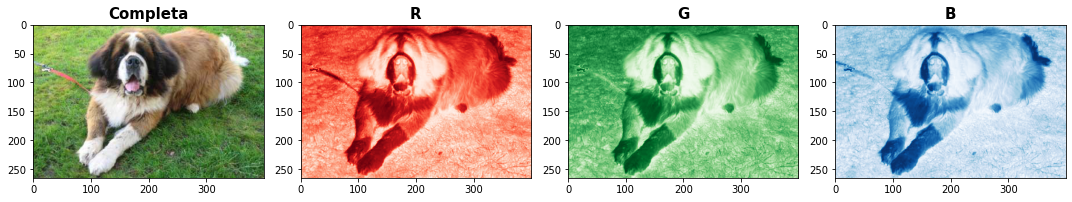

In [ ]:
f, ax = plt.subplots(1, 4, figsize=[15,15])
titles = ['Completa', 'R', 'G', 'B']
cmaps = ['Reds', 'Greens', 'Blues']
for i in range(4):
    if i == 0:
        ax[i].imshow(dog)
    else:
        ax[i].imshow(dog[:,:,i-1], cmap=cmaps[i-1])
    ax[i].set_title(titles[i], fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

Em geral na Física imagens não vêm nos formatos comuns achados na internet. Observatórios astronômicos em geral usam arquivos `.fits`, enquanto dados advindo de simulações pode vir diretamente como numpy arrays.

A comunidade pithonica já tem pacotes destinados a realizar tarefas comuns em astronomia, o `astropy`, que pode ser usado para ler arquivos `.fits`.

In [8]:
pillars_img = np.zeros((1600, 1600, 3))
cwd = '/content'
i = 0
for f in os.listdir(cwd):
    if 'nmos' in f:
        hst = fits.open(os.path.join(cwd, f))
        header = hst[0].header
        img = hst[0].data
        print(type(img), img.shape)
        img = np.transpose(img)
        pillars_img[:,:,i] = img
        i+=1

<class 'numpy.ndarray'> (1600, 1600)
<class 'numpy.ndarray'> (1600, 1600)
<class 'numpy.ndarray'> (1600, 1600)


In [ ]:
pillars_img_norm = np.zeros_like(pillars_img)
for i in range(3):
    band = pillars_img[:,:,i]
    band_filled = np.ma.log(band).filled(0)
    #print(band_filled.max())
    pillars_img_norm[:,:,i] = (band_filled - band_filled.min()) / np.ptp(band_filled)

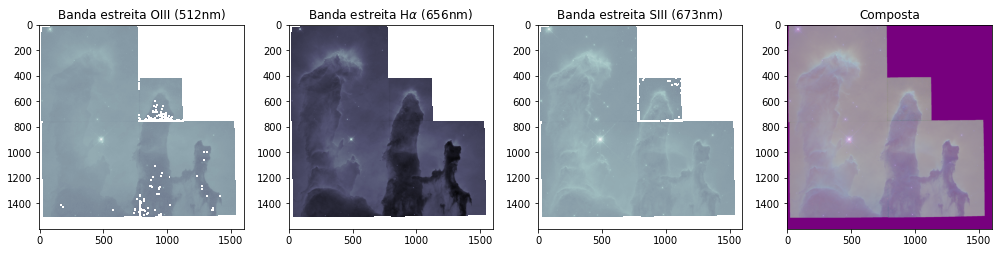

In [ ]:
names = ['Banda estreita OIII (512nm)', r'Banda estreita H$\alpha$ (656nm)', 'Banda estreita SIII (673nm)', 'Composta']
f, ax = plt.subplots(1, 4, figsize=[14,6])
for i in range(4):
    if i == 3:
        ax[i].imshow(pillars_img_norm)
        ax[i].set_title(names[i])
    else:
        ax[i].imshow(np.ma.log10(pillars_img[:,:,i]), cmap='bone')
        ax[i].set_title(names[i])
plt.tight_layout()
plt.show()

In [ ]:
print(f'Menor valor de pixel = {pillars_img.min()}\nMaior valor do pixel = {pillars_img.max()}')

Menor valor de pixel = -15.075413703918457
Maior valor do pixel = 3363.962890625


E finalmente, para arquivos salvos diretamente como numpy arrays, o carregamento é imediato

In [9]:
vis = np.load('/content/vis_cut_test_o2i.npy')
hjy = np.load('/content/hjy_cut_test_o2i.npy')
labels = np.load('/content/y_cut_test_o2i.npy')

## 2. Pré processamento

Os dados acima são uma parte das imagens disponibilizadas pelo II Strong Gravitational Lens Challenge, um desafio aberto a pesquisadores de todo mundo para classificação de imagens com/sem lenteamento gravitacional forte. As simulações visaram emular o que seria observado no observatório espacial **EUCLID**, que ainda está para ser lançado. Essa seleção tem 1000 imagens no filtro VIS e 1000 nos filtros H, J e Y. 

Vamos analisar algumas

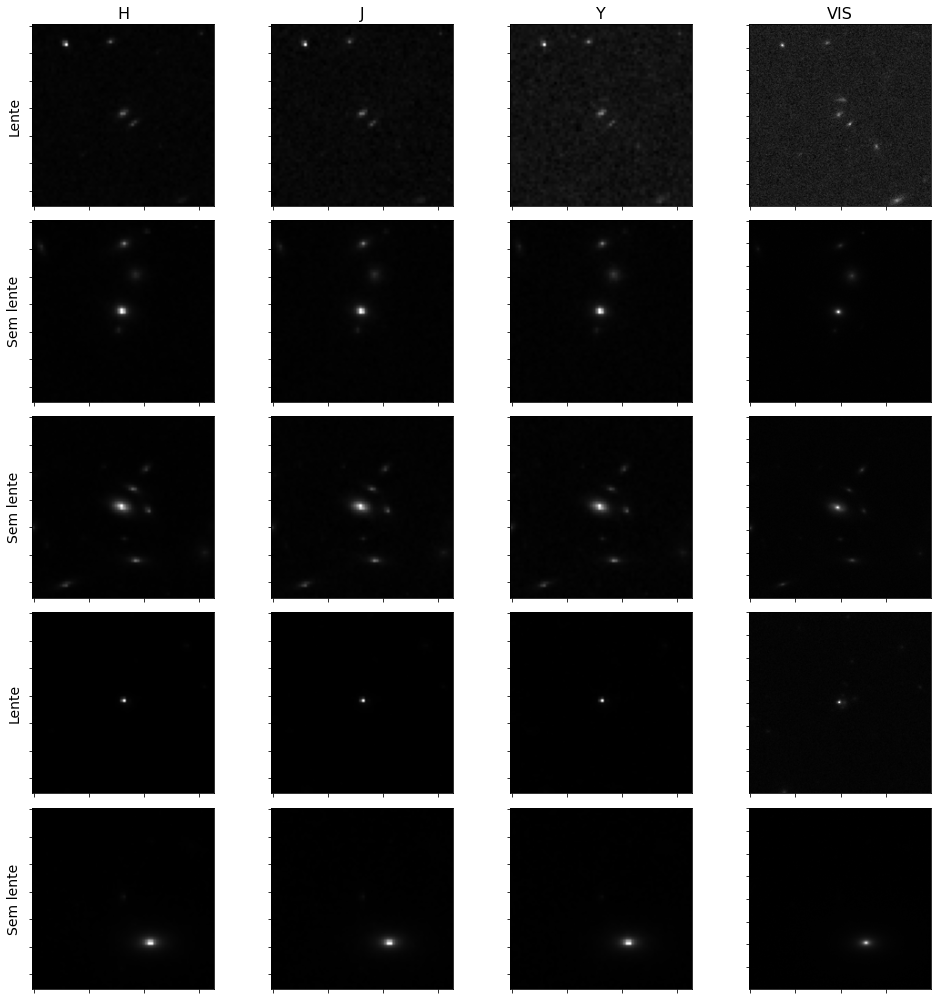

In [ ]:
f, ax = plt.subplots(5, 4, figsize=[14,14])
indices = np.random.choice(range(vis.shape[0]), 5, replace=False)
titles = ['H', 'J', 'Y', "VIS"]
lab_names = ['Sem lente', 'Lente']
for i, ii in enumerate(indices):
    ax[i,0].set_ylabel(lab_names[labels[ii].argmax()], fontsize=14)
    for j in range(3):
        ax[i,j].imshow(hjy[ii,:,:,j], cmap='binary_r')
    #ax[i,3].imshow(hjy[ii,:,:,:])
    ax[i,3].imshow(vis[ii,:,:,0], cmap='binary_r')
    for j in range(4):
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].yaxis.set_ticklabels([])
        ax[0,j].set_title(titles[j], fontsize=16)

plt.tight_layout()
plt.show()

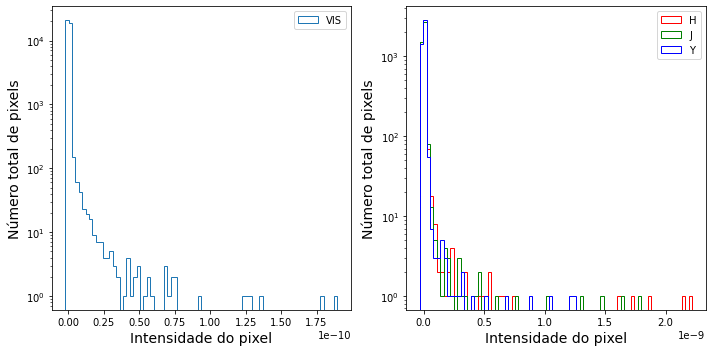

In [ ]:

f, ax = plt.subplots(1, 2, figsize=[10,5])

ax[0].hist(vis[0].ravel(), 80, histtype='step', label='VIS', log=True)
ax[0].legend(loc='upper right')
c, bins, _ = ax[1].hist(hjy[0,:,:,0].ravel(), 80, histtype='step', color='r', label='H')
ax[1].hist(hjy[0,:,:,1].ravel(), bins, histtype='step', color='g', label='J')
ax[1].hist(hjy[0,:,:,2].ravel(), bins, histtype='step', color='b', label='Y', log=True)
ax[1].legend(loc='upper right')
for i in range(2):
    ax[i].set_xlabel('Intensidade do pixel', fontsize=14)
    ax[i].set_ylabel('Número total de pixels', fontsize=14)
plt.tight_layout()
plt.show()

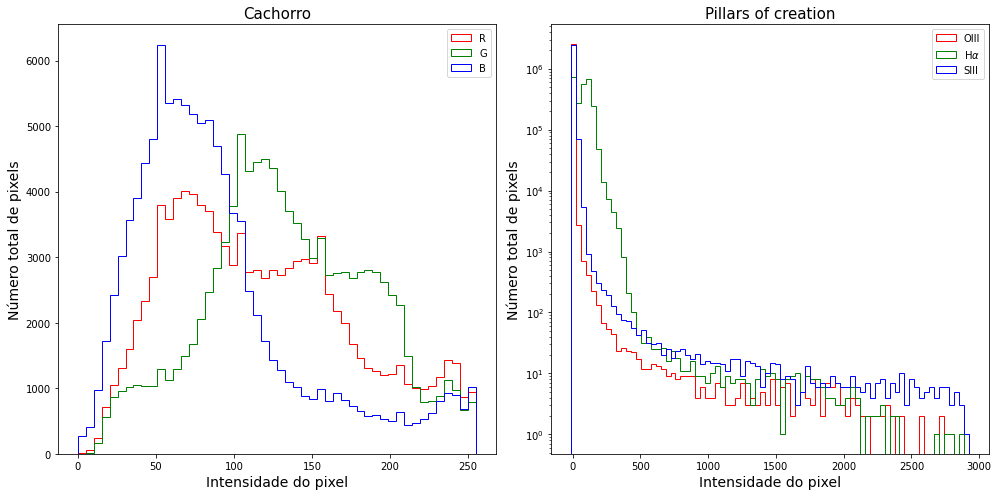

In [ ]:
f, ax = plt.subplots(1, 2, figsize=[14,7])

c_d, bins_d,  _ = ax[0].hist(dog[:,:,0].ravel(), 50, histtype='step', color='r', label='R')
ax[0].hist(dog[:,:,1].ravel(), bins_d, histtype='step', color='g', label='G')
ax[0].hist(dog[:,:,2].ravel(), bins_d, histtype='step', color='b', label='B')
ax[0].legend(loc='upper right')
ax[0].set_title('Cachorro', fontsize=15)
c, bins, _ = ax[1].hist(pillars_img[:,:,0].ravel(), 80, histtype='step', color='r', label='OIII')
ax[1].hist(pillars_img[:,:,1].ravel(), bins, histtype='step', color='g', label=r'H$\alpha$')
ax[1].hist(pillars_img[:,:,2].ravel(), bins, histtype='step', color='b', label='SIII', log=True)
ax[1].legend(loc='upper right')
ax[1].set_title('Pillars of creation', fontsize=15)
for i in range(2):
    ax[i].set_xlabel('Intensidade do pixel', fontsize=14)
    ax[i].set_ylabel('Número total de pixels', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
print(f'Pixel minimo em VIS = {vis.min()} --- Pixel maximo em VIS = {vis.max()}')
filters = 'HJY'
for i, b in enumerate(filters):
    print(f'Pixel minimo em {b} = {hjy[:,:,:,i].min()} --- Pixel maximo em {b} = {hjy[:,:,:,i].max()}')

Pixel minimo em VIS = -2.796088447581946e-12 --- Pixel maximo em VIS = 2.2612381300746165e-08
Pixel minimo em H = -4.043149148813541e-11 --- Pixel maximo em H = 3.795917393745185e-07
Pixel minimo em J = -4.837595601880906e-11 --- Pixel maximo em J = 3.4678089377848664e-07
Pixel minimo em Y = -4.635460765234356e-11 --- Pixel maximo em Y = 3.022305747890641e-07


In [ ]:
vis_log = np.log10(vis + np.abs(1.001*vis.min()))
hjy_log = np.zeros_like(hjy)
for i in range(3):
    band = hjy[:,:,:,i]
    band_log = np.log10(band + np.abs(1.001*band.min()))
    hjy_log[:,:,:,i] = band_log

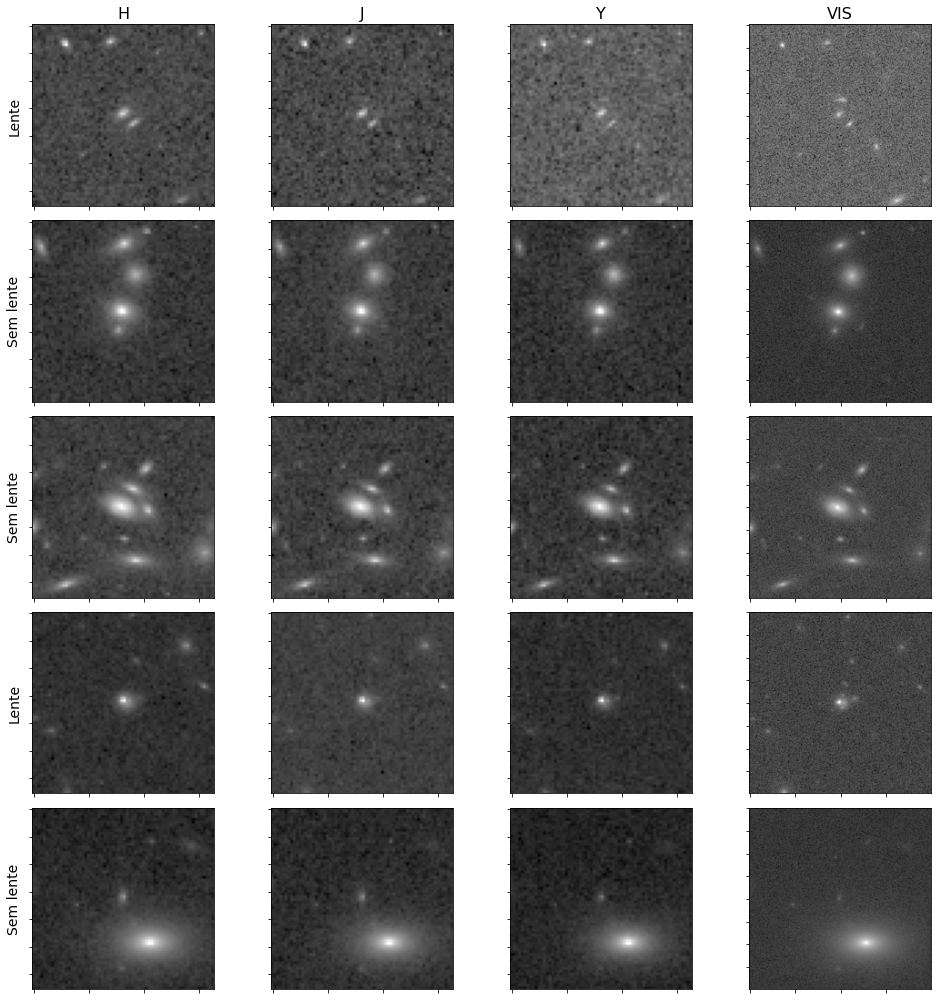

In [ ]:
f, ax = plt.subplots(5, 4, figsize=[14,14])
#indices = np.random.choice(range(vis.shape[0]), 5, replace=False)
titles = ['H', 'J', 'Y', "VIS"]
lab_names = ['Sem lente', 'Lente']
for i, ii in enumerate(indices):
    ax[i,0].set_ylabel(lab_names[labels[ii].argmax()], fontsize=14)
    for j in range(3):
        ax[i,j].imshow(hjy_log[ii,:,:,j], cmap='binary_r')
    #ax[i,3].imshow(hjy[ii,:,:,:])
    ax[i,3].imshow(vis_log[ii,:,:,0], cmap='binary_r')
    for j in range(4):
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].yaxis.set_ticklabels([])
        ax[0,j].set_title(titles[j], fontsize=16)

plt.tight_layout()
plt.show()

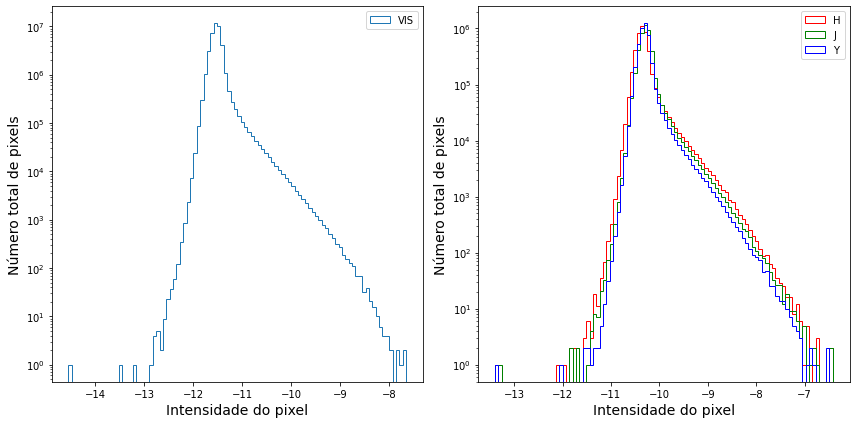

In [ ]:

f, ax = plt.subplots(1, 2, figsize=[12,6])

ax[0].hist(vis_log.ravel(), 100, histtype='step', label='VIS', log=True)
ax[0].legend(loc='upper right')
c, bins, _ = ax[1].hist(hjy_log[:,:,:,0].ravel(), 100, histtype='step', color='r', label='H')
ax[1].hist(hjy_log[:,:,:,1].ravel(), bins, histtype='step', color='g', label='J')
ax[1].hist(hjy_log[:,:,:,2].ravel(), bins, histtype='step', color='b', label='Y', log=True)
ax[1].legend(loc='upper right')
for i in range(2):
    ax[i].set_xlabel('Intensidade do pixel', fontsize=14)
    ax[i].set_ylabel('Número total de pixels', fontsize=14)
plt.tight_layout()
plt.show()

### Outra possīvel solução: cortes de contraste

In [ ]:
def clip_image(img, pmin, pmax):
    img_min = np.percentile(img, pmin)
    img_max = np.percentile(img, pmax)
    clipped = np.clip(img, img_min, img_max)
    return clipped

In [ ]:
vis_clipped = clip_image(vis, 0.5, 98)
hjy_clipped = np.zeros_like(hjy)
for i in range(3):
    band = hjy[:,:,:,i]
    band_clipped = clip_image(band, 0.5, 98)
    hjy_clipped[:,:,:,i] = band_clipped

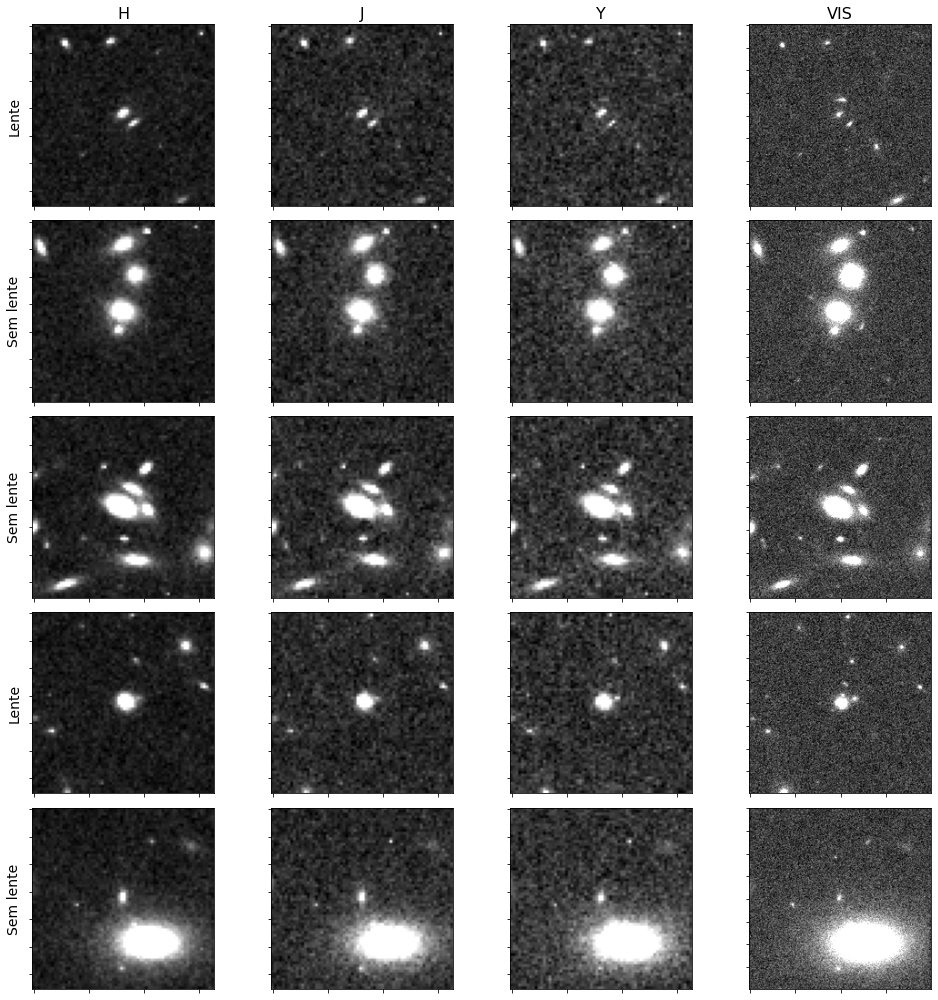

In [ ]:
f, ax = plt.subplots(5, 4, figsize=[14,14])
i#ndices = np.random.choice(range(vis.shape[0]), 5, replace=False)
titles = ['H', 'J', 'Y', "VIS"]
lab_names = ['Sem lente', 'Lente']
for i, ii in enumerate(indices):
    ax[i,0].set_ylabel(lab_names[labels[ii].argmax()], fontsize=14)
    for j in range(3):
        ax[i,j].imshow(hjy_clipped[ii,:,:,j], cmap='binary_r')
    #ax[i,3].imshow(hjy[ii,:,:,:])
    ax[i,3].imshow(vis_clipped[ii,:,:,0], cmap='binary_r')
    for j in range(4):
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].yaxis.set_ticklabels([])
        ax[0,j].set_title(titles[j], fontsize=16)

plt.tight_layout()
plt.show()

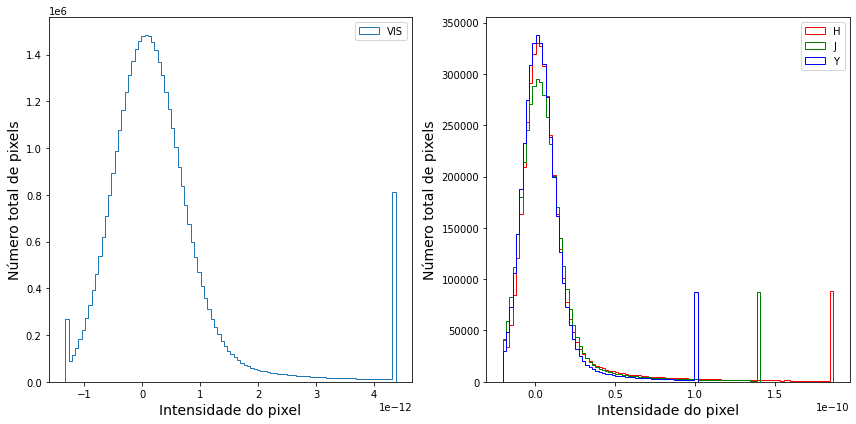

In [ ]:
f, ax = plt.subplots(1, 2, figsize=[12,6])

ax[0].hist(vis_clipped.ravel(), 100, histtype='step', label='VIS', log=False)
ax[0].legend(loc='upper right')
c, bins, _ = ax[1].hist(hjy_clipped[:,:,:,0].ravel(), 100, histtype='step', color='r', label='H')
ax[1].hist(hjy_clipped[:,:,:,1].ravel(), bins, histtype='step', color='g', label='J')
ax[1].hist(hjy_clipped[:,:,:,2].ravel(), bins, histtype='step', color='b', label='Y', log=False)
ax[1].legend(loc='upper right')
for i in range(2):
    ax[i].set_xlabel('Intensidade do pixel', fontsize=14)
    ax[i].set_ylabel('Número total de pixels', fontsize=14)
plt.tight_layout()
plt.show()

### Próximo problema:

- Imagens VIS: 200x200
- Imagens HJY: 66x66

Redes convolucionais esperam tamanhos de imagem constante. 

1. **Crop**: Cortar parte da imagem para acertar os tamanhos
1. **Resize**: Mudar o tamanho da imagem
1. Alguma outra opção?

In [ ]:
vis_resized = np.array([transform.resize(v, (66, 66, 1)) for v in vis_clipped])

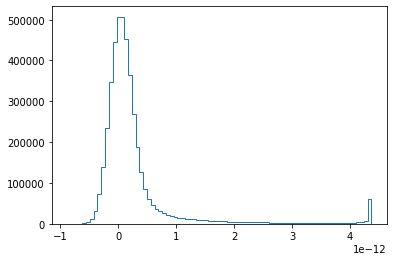

In [ ]:
plt.hist(vis_resized.ravel(), 80, histtype='step')
plt.show()

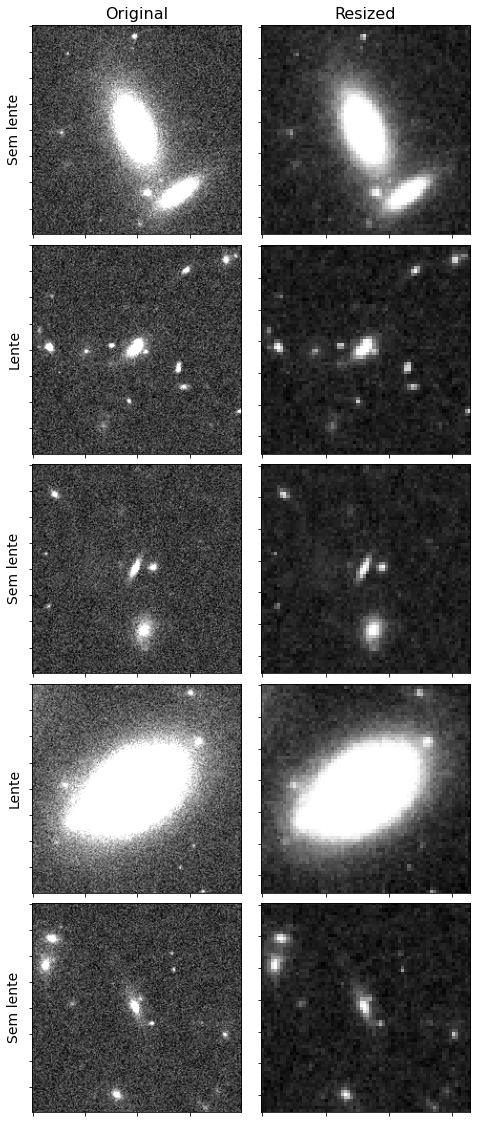

In [ ]:
f, ax = plt.subplots(5, 2, figsize=[8,20], gridspec_kw={'wspace':0.05, 'hspace':0.05})
indices = np.random.choice(range(vis.shape[0]), 5, replace=False)
titles = ['Original', 'Resized']
lab_names = ['Sem lente', 'Lente']
for i, ii in enumerate(indices):
    ax[i,0].set_ylabel(lab_names[labels[ii].argmax()], fontsize=14)
    ax[i,1].imshow(vis_resized[ii,:,:,0], cmap='binary_r') 
    ax[i,0].imshow(vis_clipped[ii,:,:,0], cmap='binary_r')
    for j in range(2):
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].yaxis.set_ticklabels([])
        ax[0,j].set_title(titles[j], fontsize=16)

#plt.tight_layout()
plt.show()

In [ ]:
hjy_resized = np.zeros((hjy_clipped.shape[:1]+vis.shape[1:-1]+(3,)))
for i, img in enumerate(hjy_clipped):
    #print(img.shape)
    res = np.array([transform.resize(img[:,:,j], (200, 200)) for j in range(3)])
    #print(res.T.shape)
    hjy_resized[i] = np.transpose(res, (1,2,0))

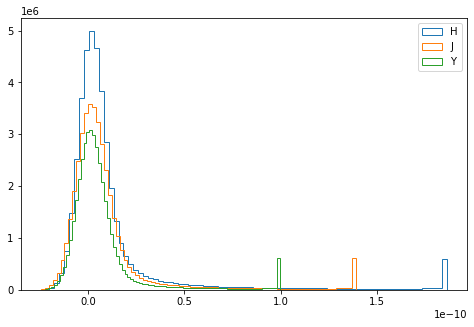

In [ ]:
plt.figure(figsize=[8,5])
bands = 'HJY'
for i in range(3):
    plt.hist(hjy_resized[:,:,:,i].ravel(), 80, histtype='step', label=bands[i])
plt.legend(loc='upper right')
plt.show()

**Outras ideias?**

## Passo final: Normalizar os inputs (importantíssimo!!!!)

Padronizar os valores dos pixels em um range menor, em geral [-1,1], [0,1], ou transformar para que tenham média =0 e desvio padrão =1. No último caso, essa variação é feita por canal, enquanto nos dois primeiros pode ser feita por canal **e** imagem. Nesse caso cada canal de cada imagem teria pixels entre [0,1]. Essas transformações ajudam na convergência da rede.

In [ ]:
def normalize_img(img):
    #exercicio
    return norm_img

In [ ]:
vis_norm = np.zeros_like(vis_clipped)
for i, img in enumerate(vis_clipped):
    vis_norm[i] = normalize_img(img)
    
hjy_norm = np.zeros_like(hjy_clipped)
for i, img in enumerate(hjy_clipped):
    hjy_norm[i] = normalize_img(img)

In [ ]:
for i, img in enumerate(hjy_norm):
    for j in range(img.shape[-1]):
        assert img[:,:,j].max() == 1.0, f'Maximo =! 1 para imagem {i}, canal {j}'
        assert img[:,:,j].min() == 0.0, f'Minimo =! 0 para imagem {i}, canal {j}'

**A normalização é usada sempre, independente do tipo de dado (imagem/tabular/sequencia)**

# 3. Aumentação de dados

Consiste em criar novos samples a partir dos já existentes, aplicando alguma transformação. Dois intuitos principais:
1. Aumentar a variação dos dados de treino e/ou o número de samples;
1. Aliviar um problema de classificação desbalanceado

Portanto, não usamos aumentação na validação nem no teste!

Em caso de imagens, podemos usar rotações, flips, zooming, cropping... Tensorflow já possui classe específica para realizar aumentação de imagens: [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

**Cuidado ao aumentar imagens: chequem se as labels também devem mudar com as transformações!**



In [ ]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=120,
                zoom_range=0.20,
                vertical_flip = True,
                horizontal_flip=True,
                #width_shift_range=[-50, 50],
                #height_shift_range=[-50, 50],
                #shear_range=50,
                fill_mode="nearest")



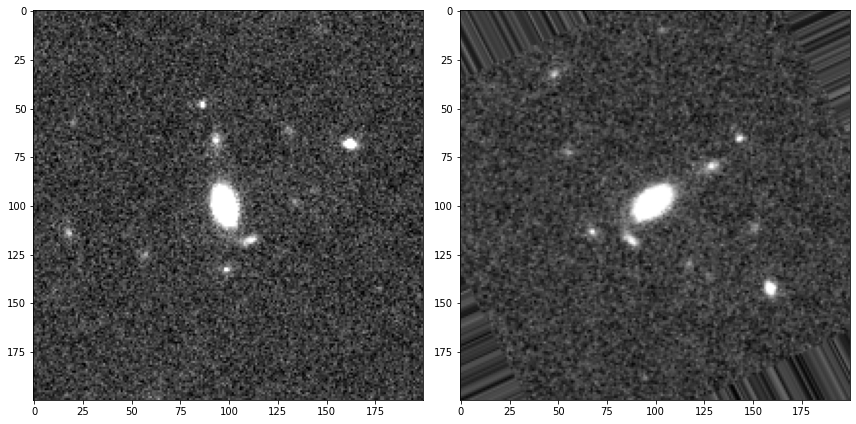

In [ ]:
generator = gen.flow(vis_clipped[:1], batch_size=1)
f, ax = plt.subplots(1, 2, figsize=[12,8])
ax[0].imshow(vis_clipped[0,...,0], cmap='binary_r')
#ax[1].imshow(hjy_clipped[0,:,:,1], cmap='binary_r')
ax[1].imshow(next(generator)[0,...,0], cmap='binary_r')

plt.tight_layout()
plt.show()

In [ ]:
def create_cnn_model(inp_size):
    inp = tf.keras.layers.Input(inp_size)
    x = tf.keras.layers.Conv2D(32, 2, strides=1)(inp)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(20, activation='relu')(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)
    
    model = tf.keras.models.Model(inp, x)
    return model

model = create_cnn_model(vis_clipped.shape[1:])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#gen_train = gen.flow(vis_clipped, labels, batch_size=16)

history = model.fit(gen.flow(vis_clipped, labels, batch_size=16), epochs=10, steps_per_epoch=vis_clipped.shape[0] // 16)

Epoch 1/10
53/62 [========================>.....] - ETA: 3s - loss: 0.6933 - accuracy: 0.5119

KeyboardInterrupt: ignored

### Exercícios 

1. Brincar com o corte de contraste: visualmente quais valores são melhores? Há muita diferença?
1. Testar outros tipos de pré-processamento.
1. Sugestão para usar HJY e VIS em uma rede sem resize ou crop. ([possível solução](https://arxiv.org/abs/2203.09536)).
1. Criar a função de normalização por imagem **E** canal.
1. Criar um gerador de aumentação de dados que funcione com 2 tipos de input diferentes (como HJY e VIS).